# Numerical results for RTS-96

In [1]:
####### IMPORTS ########
include("../src/tmp_inst_rts96.jl")
include("../src/TemporalInstanton.jl")
include("../src/TemporalInstanton2.jl")

using TemporalInstanton,TemporalInstanton2

####### LOAD DATA ########
psData = psDataLoad()

# unpack psDL (boilerplate):
(Sb,f,t,r,x,b,Y,bustype,
Gp,Gq,Dp,Dq,Rp,Rq,
Pmax,Pmin,Qmax,Qmin,Plim,
Vg,Vceiling,Vfloor,
busIdx,N,Nr,Ng,k) = unpack_psDL(psData)

####### LINK DATA ########
# Static
Ridx = find(Rp) # Vector of renewable nodes
Y = full(Y) # Full admittance matrix (ref not removed)
ref = 1 # Index of ref node
k = k # Conventional generator participation factors
tau = 1. # Heating constant
G0 = [0.8*Gp,0.8*Gp,0.8*Gp]
D0 = [Dp,Dp.*0.95,Dp.*0.9]
P0 = [Rp,Rp,Rp]
kQobj = 0 # Should always be zero; objective has no constant term
c = 0.5 # RHS of line temperature constraint
kQtheta = -c # Move to LHS so we have Q(z) = 0
lines = [(f[i],t[i]) for i in 1:length(f)];

n = size(Y,1)
nr = length(Ridx)
T = int(length(G0)/n) # infer number of time steps

# Create Qobj:
Qobj = tmp_inst_Qobj(n,nr,T)
# Augment Qobj with additional rows and columns of zeros:
Qobj = tmp_inst_pad_Q(full(Qobj),T)

# Create A1 (only A2 changes during opt.):
A1 = full(tmp_inst_A(Ridx,T,Y,ref,k))
A1 = [A1 zeros((n+1)*T,T)]

# Create b:
b = tmp_inst_b(n,T,G0,P0,D0)
# Augment b with new elements:
tmp_inst_pad_b(b,T)

# Create Qtheta:
Qtheta = tmp_inst_Qtheta(n,nr,T)#,tau)

# Form obj and constraint quadratics:
G_of_x = (Qobj,0,kQobj)
Q_of_x = (Qtheta,0,kQtheta)

println("loaded")

loaded


In [2]:
score,x,θ,α,diffs,xopt = loop_through_lines(
    G_of_x,Q_of_x,A1,b,
n,T,tau,Ridx,ref,lines)

println("solved")

solved


In [3]:
sum(score.==Inf)

55

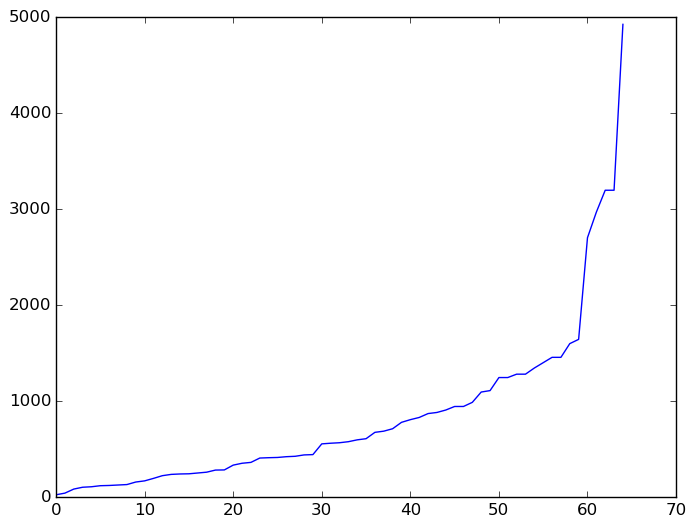

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc0ed2f1d90>

In [32]:
plot(sort(score[score.<Inf]))

In [4]:
@time(loop_through_lines(
    G_of_x,Q_of_x,A1,b,
n,T,tau,Ridx,ref,lines))

println("solved")

elapsed time: 67.819097441 seconds (14913261356 bytes allocated, 16.59% gc time)
solved


In [4]:
using Interact
using PyPlot

INFO: Loading help data...


In [5]:
@manipulate for c = 0.05:0.05:10
    kQtheta = -c
    Q_of_x = (Qtheta,0,kQtheta)
    score,x,θ,α,diffs = loop_through_lines(
        G_of_x,Q_of_x,A1,b,
        n,T,tau,Ridx,ref,lines[118:118])
    #max_dev = maximum(abs([x[1][1],x[1][2],x[1][3]]))
    sort(P0[find(P0)] + [x[1][1],x[1][2],x[1][3]])
end

Slider{Float64}([Input{Float64}] 5.0,"c",5.0,0.05:0.05:10.0)

54-element Array{Float64,1}:
 -4.1928  
 -4.11999 
 -4.04719 
 -3.9007  
 -3.82739 
 -3.80172 
 -3.75409 
 -3.72967 
 -3.65762 
  0.389147
  0.390122
  0.391097
  0.467151
  ⋮       
  3.80628 
  3.86404 
  3.87023 
  3.92179 
  3.93627 
  4.00231 
  4.46805 
  4.52341 
  4.53653 
  4.58682 
  4.60502 
  4.65023 

In [13]:
indmin(score)

118

In [24]:
α[118]

3-element Array{Float64,1}:
 -45.8559
 -43.9706
 -42.0853

In [21]:
norm([x[118][1],x[118][2],x[118][3]])

8.203421930939346